In [33]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.layouts import row

%matplotlib inline


# PCAs - general data exploration
* PUDs and TUDs
* Area inundation from SLR 

### PUD and TUD distributions for the PCA network

PCA shapefile for PUDs and TUDs is the one provided here: https://abag.ca.gov/priority/conservation/, dissolved on 'joinkey', which appears to be a unique identifier.

In [34]:
pudtable = pd.read_csv('../flickr/userdays_avg_annual_bypid.csv')
pudtable.rename(columns={'avg_ann_ud':'pud'}, inplace=True)

In [35]:
tudtable = pd.read_csv('../twitter/userdays_avg_annual_bypid.csv')
tudtable.rename(columns={'avg_ann_ud':'tud'}, inplace=True)

In [36]:
data = pudtable.merge(tudtable, on='pid')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb78b30f4a8>], dtype=object)

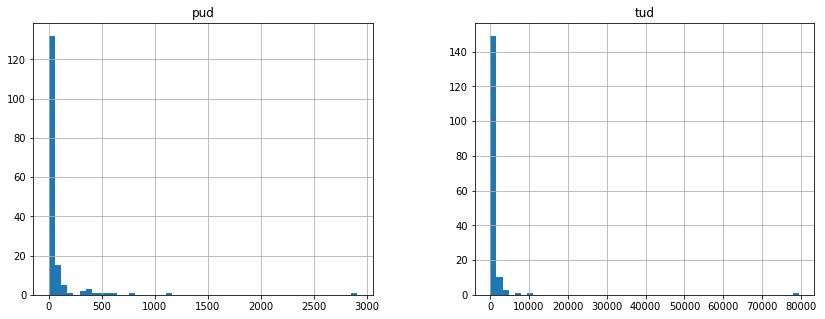

In [37]:
fig, axs = plt.subplots(1,2, figsize=(14,5))
data.hist('pud', bins=50, ax=axs[0])
data.hist('tud', bins=50, ax=axs[1])

In [38]:
data['logpud'] = np.log1p(data['pud'])
data['logtud'] = np.log1p(data['tud'])

### PUD and TUD are correlated, but capture slightly different visitation patterns

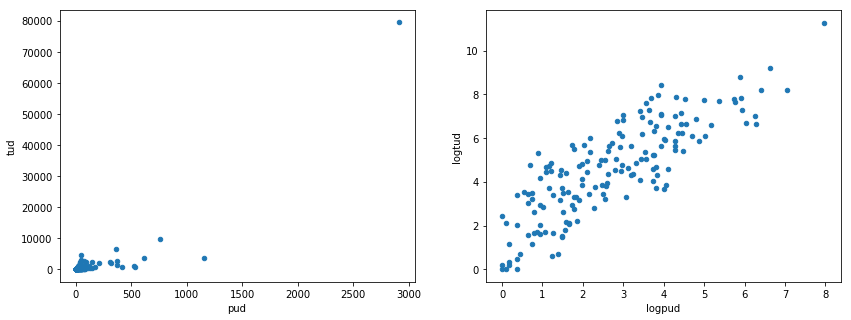

In [39]:
fig, axs = plt.subplots(1,2, figsize=(14,5))
data.plot.scatter(x='pud', y='tud', ax=axs[0])
data.plot.scatter(x='logpud', y='logtud', ax=axs[1])

### PUD, TUD are influenced by area of PCA

In [40]:
pca_shp = gpd.read_file('../twitter/shp/Priority_Conservation_Areas_current_dissolve_pid.shp')

In [41]:
pca_shp['area_m2'] = pca_shp.area
data = data.merge(pca_shp[['area_m2', 'pid', 'name', 'joinkey']], on='pid')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb79368ed68>]], dtype=object)

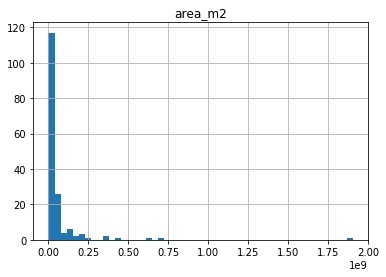

In [42]:
data.hist('area_m2', bins=50)

In [43]:
data['logarea'] = np.log1p(data['area_m2'])

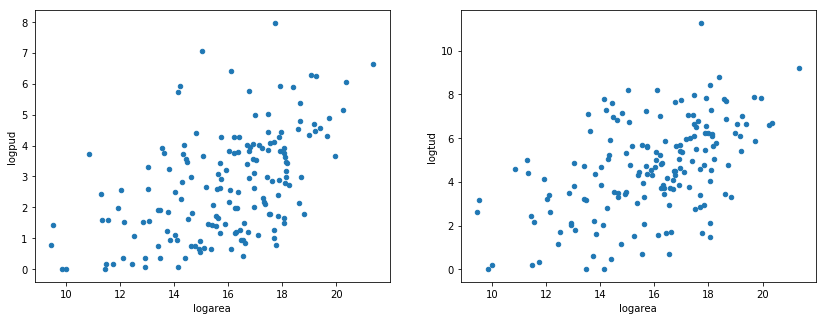

In [44]:
fig, axs = plt.subplots(1,2, figsize=(14,5))
data.plot.scatter(x='logarea', y='logpud', ax=axs[0])
data.plot.scatter(x='logarea', y='logtud', ax=axs[1])

In [45]:
data['pud_per_m2'] = data['pud']/data['area_m2']
data['tud_per_m2'] = data['tud']/data['area_m2']

#### break visitation density measures into deciles, so we can easily glance at the top 10% of PCAs, for example

In [46]:
data['pudden_tile'] = pd.qcut(data['pud_per_m2'], q=10, labels=False)
data['tudden_tile'] = pd.qcut(data['tud_per_m2'], q=10, labels=False)

## Explore PCA SLR inundation

What percentage of each PCA (and the network as a whole) is vulnerable to SLR inundation?  
And how does recreation importance of PCAs vary with SLR vulnerability?

In [47]:
# SLR shapefiles, downloaded as .gdb from https://coast.noaa.gov/slrdata/
# explored in QGIS and exported shps for appropriate layers
slr = gpd.read_file('../slr/CA_MTR23_slr_6ft.shp')
slr.crs

{'init': 'epsg:26910'}

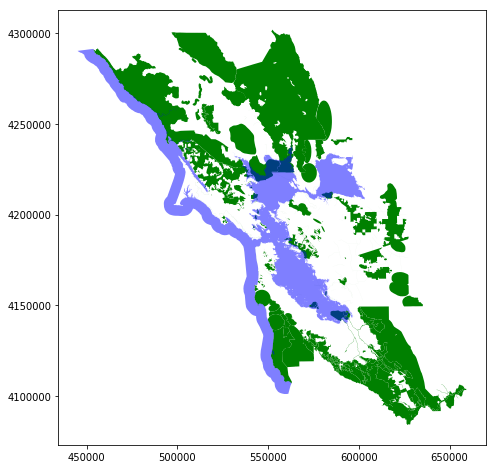

In [48]:
base = pca_shp.plot(color='green', edgecolor=None, figsize=(8,8))
slr.plot(ax=base, color='blue', alpha=0.5)

#### load table with area-inundated calculations - produced by pca_slr_intersect.py

In [49]:
inundation = pd.read_csv('pca_area_inundated_slr6ft.csv')

In [50]:
inundation.head()

,pid,area_m2
0,0,0.000000e+00
1,1,5.032777e+06
2,2,0.000000e+00
3,3,0.000000e+00
4,4,0.000000e+00


In [51]:
inundation.shape[0] == data.shape[0]

True

In [52]:
data['flood_area'] = inundation['area_m2']
data['pr_flooded'] = data['flood_area'] / data['area_m2']

### Add Designation type of each PCA to the table

#### load some PCA metadata - the 'designation' of each PCA as:
NL = Natural Landscape  
AL = Agricultural Land  
UG = Urban Greening  
RR = Regional Recreation

In [58]:
designation = pd.read_csv('../pca/FINAL_List_of_165_PCAs_Designations.csv')
# Source: https://abag.ca.gov/priority/conservation/pdfs/FINAL_List_of_165_PCAs_Approved_as_of_September_2015.pdf

In [59]:
designation['NL'] = designation['Designation'].str.extract('(NL)')
designation['AL'] = designation['Designation'].str.extract('(AL)')
designation['UG'] = designation['Designation'].str.extract('(UG)')
designation['RR'] = designation['Designation'].str.extract('(RR)')

/home/dmf/miniconda3/envs/geowork/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':
/home/dmf/miniconda3/envs/geowork/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from ipykernel import kernelapp as app
/home/dmf/miniconda3/envs/geowork/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  app.launch_new_instance()
/home/dmf/miniconda3/envs/geowork/lib/python3.6/site-packages/ipykernel/__main__.py

In [62]:
data = pd.merge(data, designation, left_on='joinkey', right_on='Area ID')

In [64]:
data.shape

(164, 21)

### PCAs most inundated -- sorted by proportion of their area that would flood with 6ft of SLR

In [65]:
data[['name', 'pud', 'tud', 'area_m2', 'flood_area', 'pr_flooded']].sort_values(by='pr_flooded', ascending=False).head(15)

,name,pud,tud,area_m2,flood_area,pr_flooded
25,"Central Marin Bayfront, Madera Bay Park",40.727273,186.2,1.632486e+06,1.621339e+06,0.993172
36,Baylands,3.363636,3.6,4.137853e+06,4.095131e+06,0.989675
40,Site 1-Coyote Hills,8.636364,15.2,1.536279e+06,1.488682e+06,0.969018
141,Menlo Park and East Palo Alto Baylands,41.545455,183.6,1.084942e+07,1.026776e+07,0.946387
151,Baylands,150.545455,445.0,3.835250e+07,3.421522e+07,0.892125
22,"Central Marin Bayfront, Canalways",15.636364,157.2,1.593893e+06,1.418095e+06,0.889705
69,San Francisco Bay Area Water Trail,40.636364,96.6,5.157240e+04,4.403055e+04,0.853762
111,Point Edith Wetlands Area,3.454545,40.6,1.564446e+07,1.313765e+07,0.839764
15,Bothin Waterfront,42.000000,562.8,8.236991e+05,6.724061e+05,0.816325
101,Potential Oakland Gateway Area,49.909091,1199.2,7.507035e+05,6.077917e+05,0.809629


### SLR vulnerability related to Visitation Rates

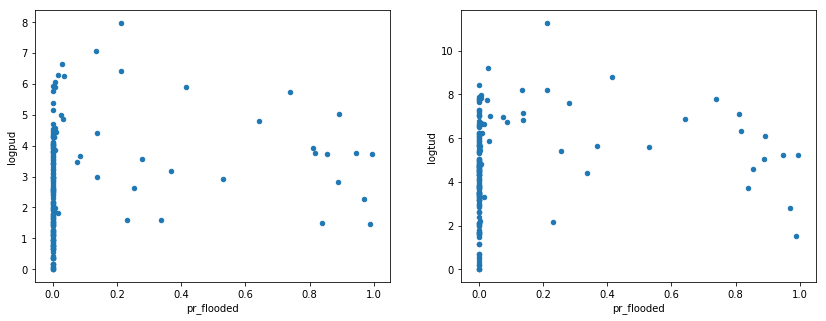

In [66]:
fig, axs = plt.subplots(1,2, figsize=(14,5))
data.plot.scatter(x='pr_flooded', y='logpud', ax=axs[0])
data.plot.scatter(x='pr_flooded', y='logtud', ax=axs[1])

In [67]:
output_notebook()

source = ColumnDataSource(data)
hover1 = HoverTool(tooltips=[("name", "@name")])
hover2 = HoverTool(tooltips=[("name", "@name")])

p = figure(plot_width=400, plot_height=400, tools=[hover1],
           title="SLR vulnerability related to Visitation Rates")

p.circle('pr_flooded', 'pud_per_m2', size=5, color='blue', alpha=0.5, source=source)
p.xaxis.axis_label = 'pr_flooded'
p.yaxis.axis_label = 'pud_per_m2'

p2 = figure(plot_width=400, plot_height=400, tools=[hover2],
           title="SLR vulnerability related to Visitation Rates")

p2.circle('pr_flooded', 'tud_per_m2', size=5, color='red', alpha=0.5, source=source)
p2.xaxis.axis_label = 'pr_flooded'
p2.yaxis.axis_label = 'tud_per_m2'

show(row(p, p2), notebook_handle=True)

Loading BokehJS ...

/home/dmf/miniconda3/envs/geowork/lib/python3.6/site-packages/bokeh/core/json_encoder.py:73: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  if pd and isinstance(obj, pd.tslib.Timestamp):


### PCAs with greater than 30% area flooded and relatively dense visitation

In [68]:
(data[['name', 'pud_per_m2', 'area_m2', 'pr_flooded']]
.loc[(data['pr_flooded'] > 0.3) & (data['pudden_tile'] >= 8)]
.sort_values(by='pud_per_m2', ascending=False)
)

,name,pud_per_m2,area_m2,pr_flooded
69,San Francisco Bay Area Water Trail,0.000788,5.157240e+04,0.853762
74,Oakland Priority Estuaries,0.000226,1.361955e+06,0.739891
101,Potential Oakland Gateway Area,0.000066,7.507035e+05,0.809629
15,Bothin Waterfront,0.000051,8.236991e+05,0.816325
71,Oakland Recreational Trails,0.000048,8.148263e+04,0.335776
25,"Central Marin Bayfront, Madera Bay Park",0.000025,1.632486e+06,0.993172
22,"Central Marin Bayfront, Canalways",0.000010,1.593893e+06,0.889705


In [69]:
(data[['name', 'tud_per_m2', 'area_m2', 'pr_flooded']]
.loc[(data['pr_flooded'] > 0.3) & (data['tudden_tile'] >= 8)]
.sort_values(by='tud_per_m2', ascending=False)
)

,name,tud_per_m2,area_m2,pr_flooded
69,San Francisco Bay Area Water Trail,0.001873,5.157240e+04,0.853762
74,Oakland Priority Estuaries,0.001789,1.361955e+06,0.739891
101,Potential Oakland Gateway Area,0.001597,7.507035e+05,0.809629
71,Oakland Recreational Trails,0.000994,8.148263e+04,0.335776
15,Bothin Waterfront,0.000683,8.236991e+05,0.816325
25,"Central Marin Bayfront, Madera Bay Park",0.000114,1.632486e+06,0.993172
22,"Central Marin Bayfront, Canalways",0.000099,1.593893e+06,0.889705


### Export Table

In [70]:
data.to_csv('../pca/pca_vis_slr_designation.csv', index=False)

In [71]:
data.head()

,pid,pud,tud,logpud,logtud,area_m2,name,joinkey,logarea,pud_per_m2,...,pudden_tile,tudden_tile,flood_area,pr_flooded,Area ID,Designation,NL,AL,UG,RR
0,0,3.545455,12.6,1.514128,2.610070,1.886378e+05,Bayview Hill Natural Area,SF9,12.147589,1.879504e-05,...,8,7,0.000000e+00,0.000000,SF9,"NL, RR",NL,NaN,NaN,RR
1,1,421.181818,815.4,6.045436,6.704904,6.879316e+08,Coastal Sonoma to Armstrong Redwoods,SN6,20.349200,6.122438e-07,...,4,1,5.032777e+06,0.007316,SN6,"NL, AL, RR",NL,AL,NaN,RR
2,2,11.909091,149.4,2.557932,5.013298,9.476046e+06,Pitkin Marsh - Atascadero Creek Watershed,SN7,16.064278,1.256757e-06,...,5,5,0.000000e+00,0.000000,SN7,NL,NL,NaN,NaN,NaN
3,3,54.272727,384.4,4.012280,5.954282,2.812273e+07,Laguna de Santa Rosa,SN4,17.152089,1.929853e-06,...,6,5,0.000000e+00,0.000000,SN4,"NL, AL, RR, UG",NL,AL,UG,RR
4,4,44.090909,709.8,3.808681,6.566391,5.933509e+07,Santa Rosa Plain,SN5,17.898712,7.430832e-07,...,4,5,0.000000e+00,0.000000,SN5,"NL, AL, RR, UG",NL,AL,UG,RR


#### joining data to shp to make some maps in qgis

In [73]:
data = pd.read_csv('../pca/pca_vis_slr_designation.csv')
shp = gpd.read_file('../twitter/shp/Priority_Conservation_Areas_current_dissolve_pid.shp')

In [ ]:
shp = shp.merge(data, on='pid')

In [ ]:
shp.to_file('../pca/pca_current_visdata.shp')

### How much of entire PCA network will be flooded?
- there's some overlap in PCAs, for now we're ignoring it.
- What portion of the PUDs in the network are in places that will be flooded? begs for a finer resolution PUD grid.

#### Percent of PCA area inundated with a 6ft SLR scenario

In [74]:
sum(data['flood_area'])/sum(data['area_m2'])*100

3.5873230994184122